In [1]:
# 多模型融合主要有两种方式：针对模型的过程进行融合、针对各个模型的输出结果进行融合

In [2]:
# 结果融合法主要包括：结果多数表决、结果直接平均、结果加权平均
# 各个模型的相关度越低，融合效果会更好，就是说各个模型输出结果的差异性越过，融合效果越好

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


X_example个数16
Y_example个数16
{'cat': 0, 'dog': 1}
['cat', 'dog']
['cat', 'cat', 'cat', 'dog', 'dog', 'dog', 'cat', 'dog', 'cat', 'dog', 'cat', 'cat', 'cat', 'cat', 'cat', 'dog']


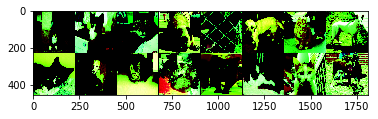

In [6]:
# 结果加权平均融合模型示例
import torch
import torchvision
import os 
import time
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision import datasets, models, transforms
from torch.autograd import Variable 

# 读取数据集
data_dir = "./data/DogsVSCats"
# 数据预处理
data_transform = {x: transforms.Compose([transforms.Resize([224,224]),
                                        transforms.ToTensor(),
                                        transforms.Normalize(
                                            mean = [0.5,0.5,0.5],
                                            std = [0.5,0.05,0.5])])
                  for x in ["train","valid"]}
# 读取数据集
image_datasets = {x: datasets.ImageFolder(root = os.path.join(data_dir,x),
                                          transform = data_transform[x])
                  for x in ["train","valid"]}
# 装载数据集
dataloader = {x: torch.utils.data.DataLoader(dataset = image_datasets[x],
                                            batch_size = 16,
                                            shuffle = True)
              for x in ["train","valid"]}

# 数据预览,注意到由于上面图片的预处理中，图片进行了normaliza,因此不是显示原图
X_example, Y_example = next(iter(dataloader['train']))
print("X_example个数{}".format(len(X_example)))
print("Y_example个数{}".format(len(Y_example)))

index_classes = image_datasets['train'].class_to_idx  # 显示类别对应的独热编码
print(index_classes)

example_classes = image_datasets['train'].classes    # 将原始图像的类别保存起来
print(example_classes)

img = torchvision.utils.make_grid(X_example)
img = img.numpy().transpose([1,2,0])
print([example_classes[i] for i in Y_example])
plt.imshow(img) 
plt.show()



In [7]:
# 构建多模型融合结构
model_1 = models.vgg16(pretrained = True)
model_2 = models.resnet50(pretrained = True)

Use_gpu = torch.cuda.is_available()

# 设置模型的参数不需要进行梯度下降
for param in model_1.parameters():
    param.requires_grad = False
model_1.classifier = torch.nn.Sequential(torch.nn.Linear(25088,4096),
                                        torch.nn.ReLU(),
                                        torch.nn.Dropout(p = 0.5),
                                        torch.nn.Linear(4096,4096),
                                        torch.nn.ReLU(),
                                        torch.nn.Dropout(p = 0.5),
                                        torch.nn.Linear(4096,2))
for param in model_2.parameters():
    param.requires_grad = False
model_2.fc = torch.nn.Linear(2048,2)

print(model_1)
print(model_2)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [8]:
# 设置损失函数以及优化方法
if Use_gpu:
    model_1 = model_1.cuda()
    model_2 = model_2.cuda()
    
loss_f_1 = torch.nn.CrossEntropyLoss()
loss_f_2 = torch.nn.CrossEntropyLoss()

optimizer_1 = torch.optim.Adam(model_1.classifier.parameters(), lr = 0.00001)
optimizer_2 = torch.optim.Adam(model_2.fc.parameters(),lr = 0.00001)

# 设置两个模型融合的权重参数
weight_1 = 0.6
weight_2 = 0.4

epoch_n = 5

In [13]:
# 训练模型
time_open = time.time()

for epoch in range(epoch_n):
    print('Epoch{}/{}'.format(epoch, epoch_n - 1))
    print('-'*10)

    for phase in ['train','valid']:
        if phase == 'train':
            print('Training...')
            model_1.train(True)
            model_2.train(True)
        else:
            print('Validing...')
            model_1.train(False)
            model_2.train(False)

        running_loss_1 = 0.0
        running_loss_2 = 0.0
        running_corrects_1 = 0.0
        running_corrects_2 = 0.0
        blending_running_corrects = 0.0

        for batch, data in enumerate(dataloader[phase], 1):
            X,y = data
            if Use_gpu:
                X,y = Variable(X.cuda()), Variable(y.cuda())
            else:
                X,y = Variable(X), Variable(y)

            y_pred_1 = model_1(X)
            y_pred_2 = model_2(X)
            blending_y_pred = y_pred_1 * weight_1 + y_pred_2 * weight_2

            _, pred_1 = torch.max(y_pred_1.data,1) # 找出每一行最大值对应的索引值
            _, pred_2 = torch.max(y_pred_2.data,1)
            _, blending_y_pred = torch.max(blending_y_pred.data,1)

            optimizer_1.zero_grad()
            optimizer_2.zero_grad()

            loss_1 = loss_f_1(y_pred_1,y)
            loss_2 = loss_f_2(y_pred_2,y)

            if phase == 'train':
                loss_1.backward()
                loss_2.backward()
                optimizer_1.step()
                optimizer_2.step()

            running_loss_1 += loss_1.data.item()
            running_loss_2 += loss_1.data.item()
            running_corrects_1 += torch.sum(pred_1 == y.data)
            running_corrects_2 += torch.sum(pred_2 == y.data)
            blending_running_corrects += torch.sum(blending_y_pred == y.data)

            cal = torch.true_divide
            if batch % 500 == 0 and phase == 'train':
                print('Batch {},Model1 Train Loss:{:.4f},\
                        Model1 Train ACC:{:.4f},Model2 Train Loss:{:.4f},\
                        Model2 Train ACC:{:.4f},Blending_Model ACC:{:.4f}'.format(
                    batch,cal(running_loss_1,batch),
                    cal(100*running_corrects_1,(16*batch)),
                    cal(running_loss_2,batch),
                    cal(100*running_corrects_2,(16*batch)),
                    cal(100*blending_running_corrects,(16*batch))))

        epoch_loss_1 = cal(running_loss_1 * 16,len(image_datasets[phase]))
        epoch_acc_1 = cal(100*running_corrects_1,len(image_datasets[phase]))
        epoch_loss_2 = cal(running_loss_2 * 16,len(image_datasets[phase]))
        epoch_acc_2 = cal(100*running_corrects_2,len(image_datasets[phase]))
        epoch_blending_acc = cal(100*blending_running_corrects,
                                 len(image_datasets[phase]))
        print('Epoch, Model1 Loss:{:.4f},Model1 ACC:{:.4f}%,\
                Model2 Loss:{:.4f},Model2 ACC:{:.4f}%,\
                Blending_Model ACC:{:.4f}'.format(epoch_loss_1,epoch_acc_1,
                        epoch_loss_2,epoch_acc_2,epoch_blending_acc))

    time_end = time.time() - time_open
    print(time_end)


Epoch0/4
----------
Training...
Batch 500,Model1 Train Loss:0.0870,                        Model1 Train ACC:96.8000,Model2 Train Loss:0.0870,                        Model2 Train ACC:94.1250,Blending_Model ACC:97.3125
Batch 1000,Model1 Train Loss:0.0845,                        Model1 Train ACC:96.9062,Model2 Train Loss:0.0845,                        Model2 Train ACC:94.3000,Blending_Model ACC:97.3938
Epoch, Model1 Loss:0.0858,Model1 ACC:96.8300%,                Model2 Loss:0.0858,Model2 ACC:94.4100%,                Blending_Model ACC:97.3300
Validing...
Epoch, Model1 Loss:0.1082,Model1 ACC:95.7000%,                Model2 Loss:0.1082,Model2 ACC:96.7600%,                Blending_Model ACC:96.7400
6562.33716750145
Epoch1/4
----------
Training...
Batch 500,Model1 Train Loss:0.0357,                        Model1 Train ACC:98.9500,Model2 Train Loss:0.0357,                        Model2 Train ACC:94.4000,Blending_Model ACC:99.0625
Batch 1000,Model1 Train Loss:0.0350,                        Mod